In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from utils import hungarian_loss
from fspool import FSPool
from model import FSEncoder
from dspn import *
from model import FSEncoderClasification
from MnistSet import MNISTSet
from MnistSet import get_loader

In [2]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=1, num_workers=2
        )

In [3]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=1, num_workers=2
        )

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import matplotlib.pyplot as plt
import numpy as np



def build_net():
    set_channels = 2
    set_size = 342
    hidden_dim = 256
    inner_lr = 800
    iters = 10
    latent_dim = 64
    input_encoder = None

    set_encoder = FSEncoder(set_channels, latent_dim, hidden_dim)
    set_decoder = DSPN(set_encoder, set_channels, set_size, hidden_dim, iters, inner_lr)
    net = Net(
        input_encoder=input_encoder, set_encoder=set_encoder, set_decoder=set_decoder
    )
    return net


class Net(nn.Module):
    def __init__(self, set_encoder, set_decoder, input_encoder=None):
        """
        In the auto-encoder setting, don't pass an input_encoder because the target set and mask is
        assumed to be the input.
        In the general prediction setting, must pass all three.
        """
        super().__init__()
        self.set_encoder = set_encoder
        self.input_encoder = input_encoder
        self.set_decoder = set_decoder

        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input, target_set, target_mask):
        if self.input_encoder is None:
            # auto-encoder, ignore input and use target set and mask as input instead
            latent_repr = self.set_encoder(target_set, target_mask)
            target_repr = latent_repr
        else:
            # set prediction, use proper input_encoder
            latent_repr = self.input_encoder(input)
            # note that target repr is only used for loss computation in training
            # during inference, knowledge about the target is not needed
            target_repr = self.set_encoder(target_set, target_mask)

        predicted_set = self.set_decoder(latent_repr)

        return predicted_set, (target_repr, latent_repr)

In [19]:
net = build_net()

In [20]:
net

Net(
  (set_encoder): FSEncoder(
    (conv): Sequential(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
    (pool): FSPool()
  )
  (set_decoder): DSPN(
    (encoder): FSEncoder(
      (conv): Sequential(
        (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (3): ReLU()
        (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      )
      (pool): FSPool()
    )
  )
)

In [21]:
optimizer = torch.optim.Adam(
    [p for p in net.parameters() if p.requires_grad], lr=0.01
)

In [22]:
data_iter = iter(train_loader)
sample = data_iter.next()

### Usando chamfer loss

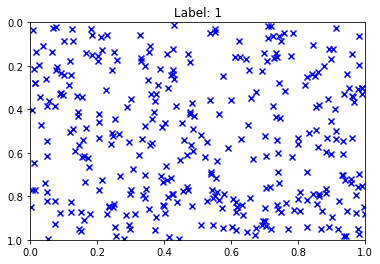

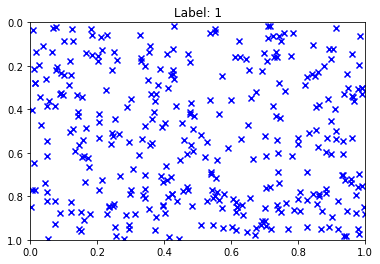

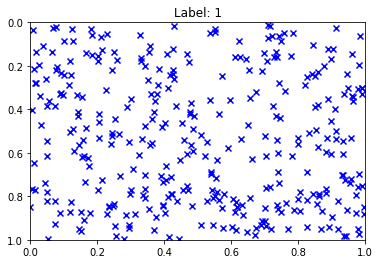

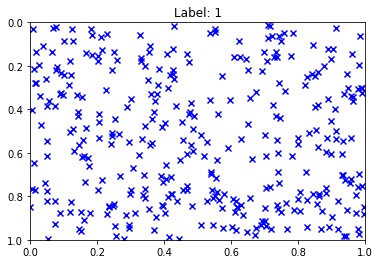

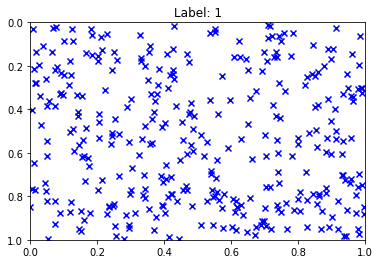

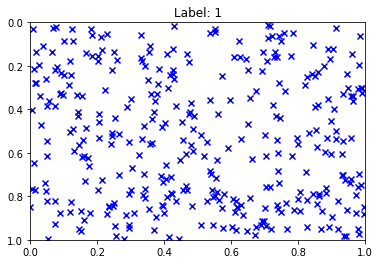

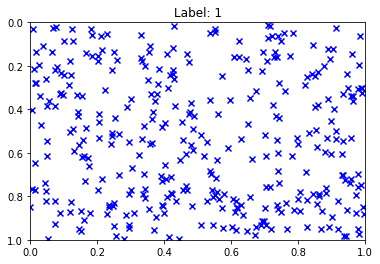

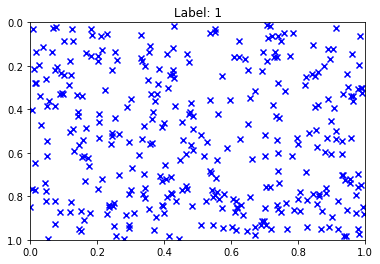

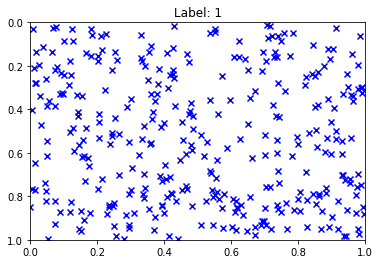

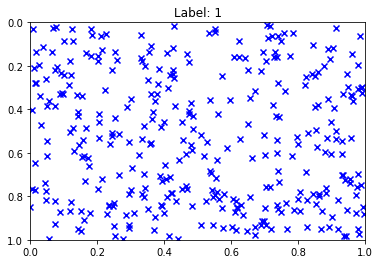

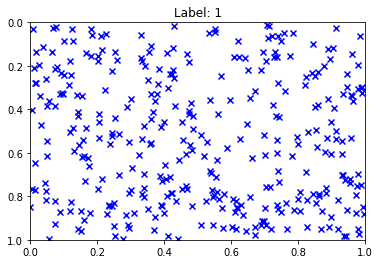

tensor([1])


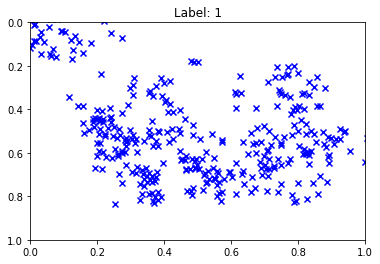

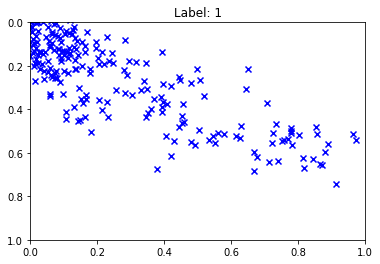

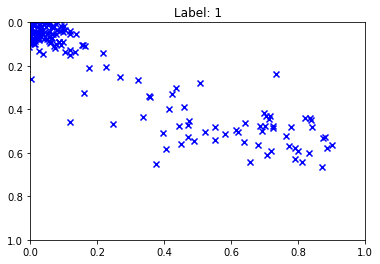

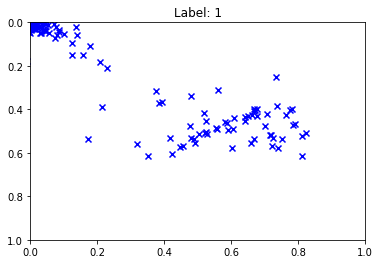

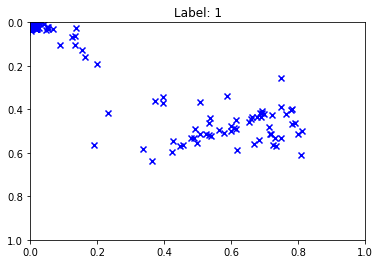

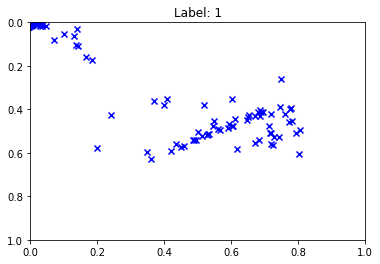

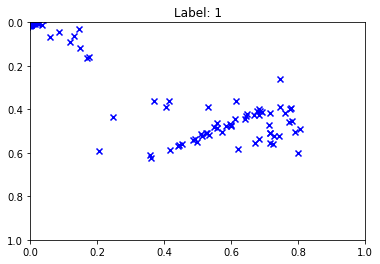

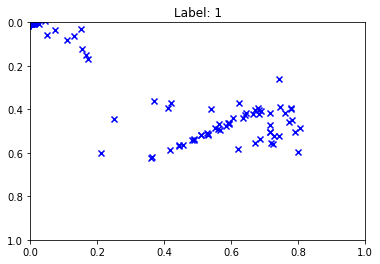

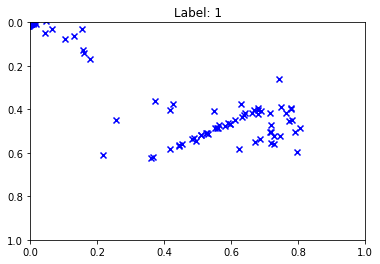

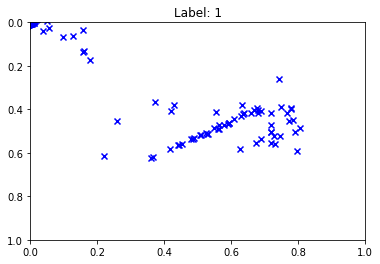

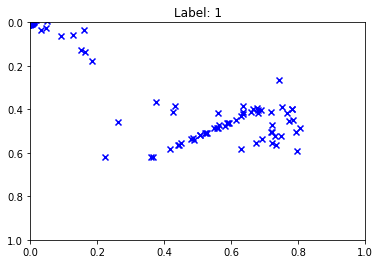

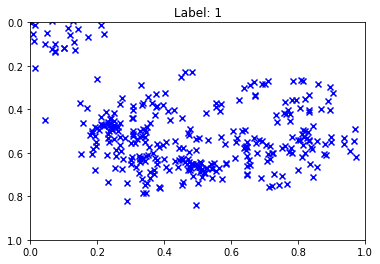

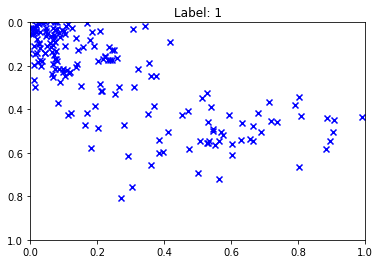

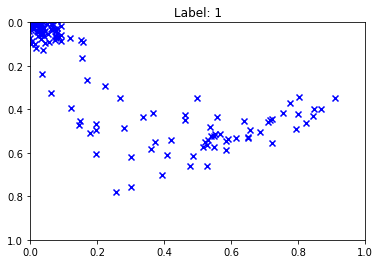

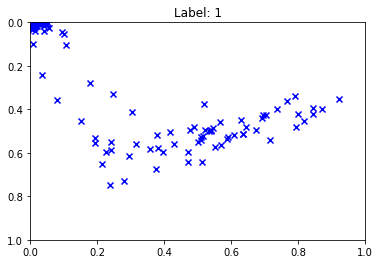

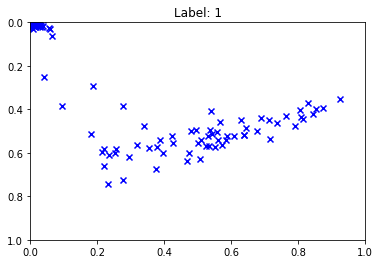

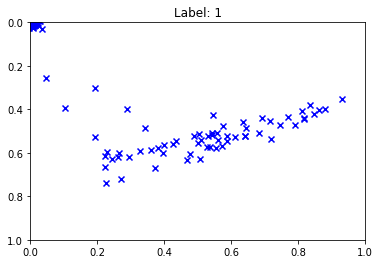

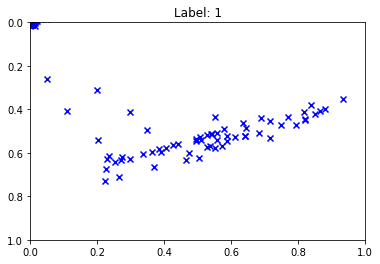

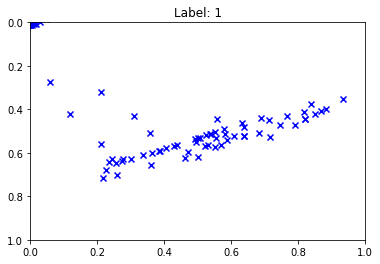

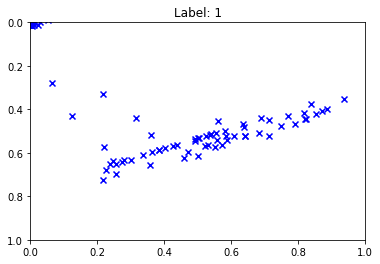

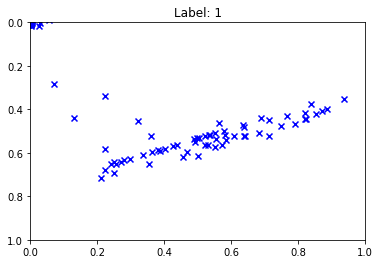

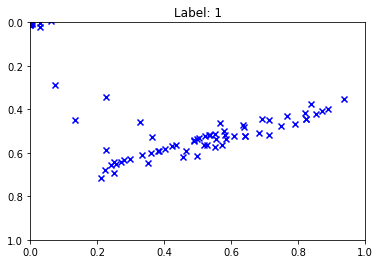

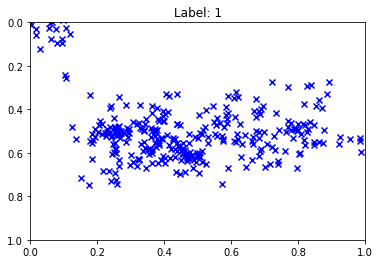

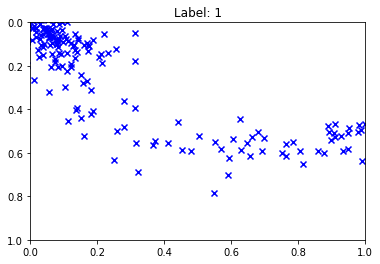

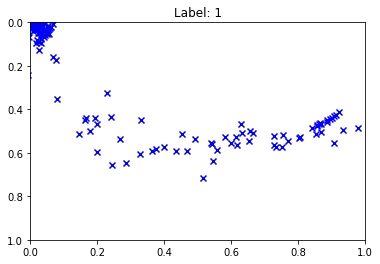

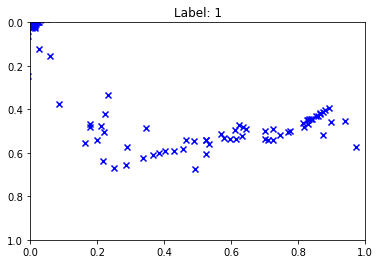

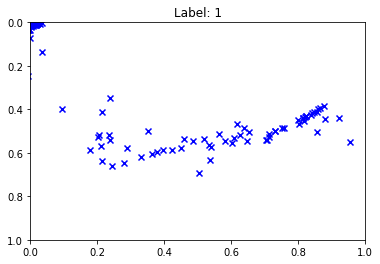

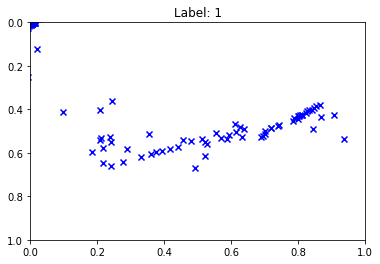

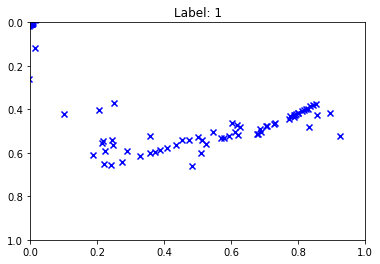

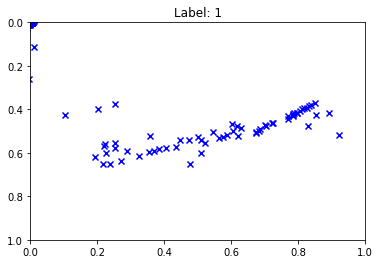

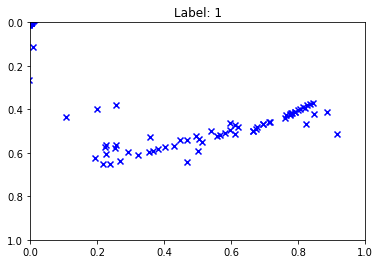

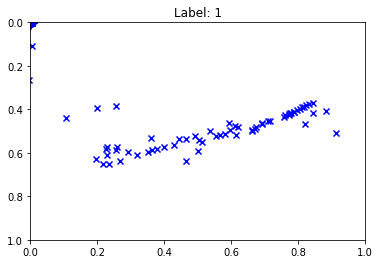

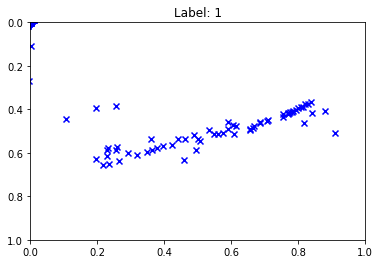

In [23]:
for i in range(100):
    input, target_set, target_mask = map(lambda x: x, sample)
    if(i == 1):
        print(input)
    (progress, masks, evals, gradn), (y_enc, y_label) = net(input, target_set, target_mask)
    if i == 0 or  i == 25 or i ==  50 or i == 99:
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
        for  a in progress:
          #print(a.shape)
            #a = a.cpu().data.numpy()
            x, y = a[0].detach().cpu().numpy()
            plt.scatter(x[:342], y[:342],marker='x',color ='b')
            #plt.axes().set_aspect("equal")
            plt.axis([0, 1, 1, 0])
            plt.title('Label: {}'.format(input[0]))
            #plt.savefig('test.png')
            plt.show()
            progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    set_loss = chamfer_loss(
      torch.stack(progress), target_set.unsqueeze(0)
    )
    loss = set_loss.mean()
    #print(set_loss)
    #print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


torch.Size([1, 3, 342])


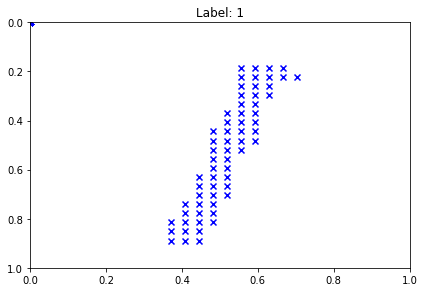

In [24]:
plt.grid(False)
plt.tight_layout()
#for  a in kk:
print(target_set.shape)
a = target_set.cpu().data.numpy()
a = a.squeeze(0)
x = a[1, :]
y = a[0, :]
plt.scatter(x, y,marker='x',color ='b')
#plt.axes().set_aspect("equal")
plt.axis([0, 1, 1, 0])
plt.title('Label: {}'.format(input.item()))
#plt.savefig('test.png')
plt.show()

### Usando Hungarian

In [25]:
netHungarian = build_net()
optimizer = torch.optim.Adam(
    [p for p in netHungarian.parameters() if p.requires_grad], lr=0.01
)

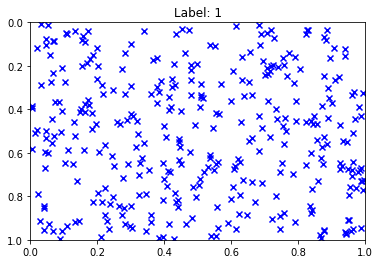

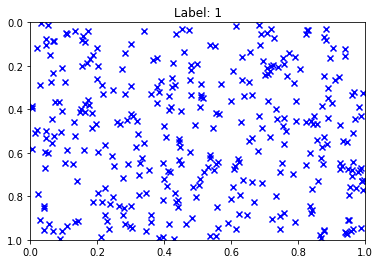

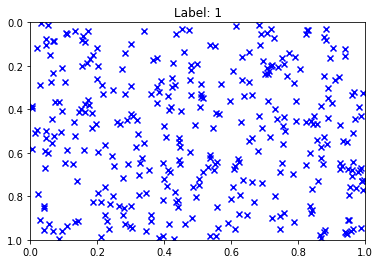

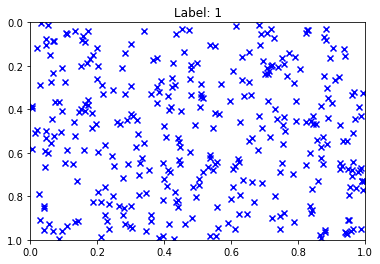

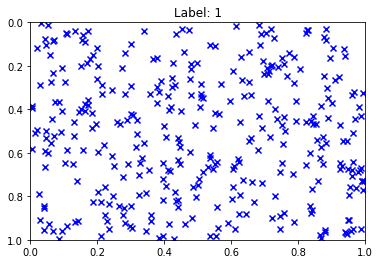

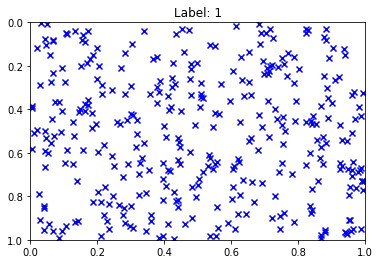

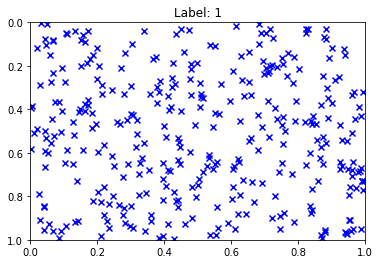

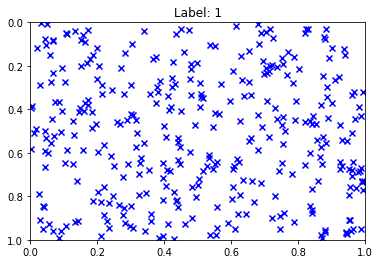

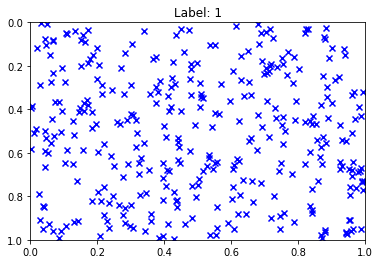

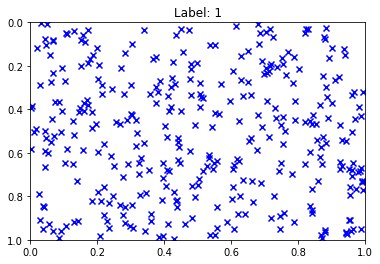

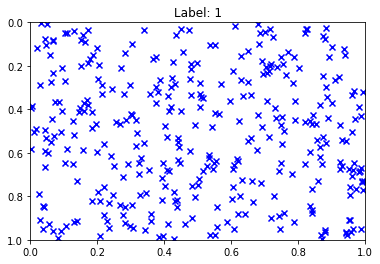

tensor(0.2393, grad_fn=<MeanBackward0>)
tensor([1])
tensor(0.1747, grad_fn=<MeanBackward0>)
tensor(0.0648, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<Mean

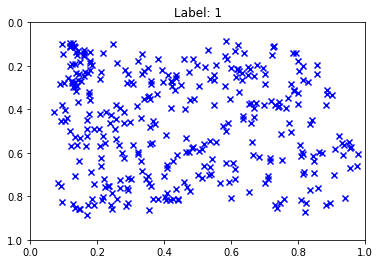

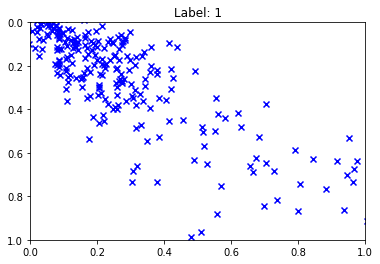

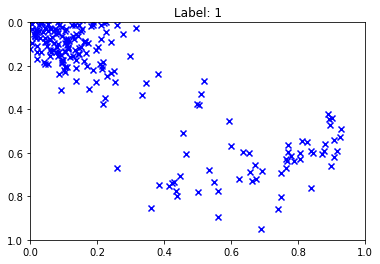

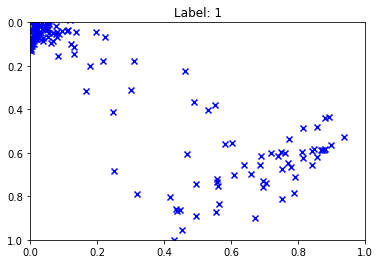

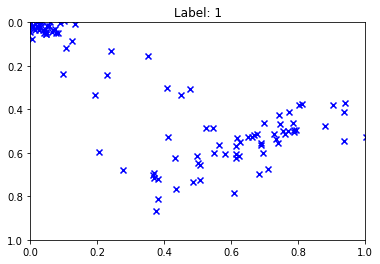

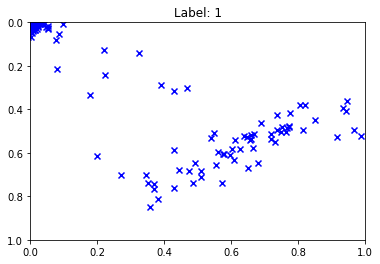

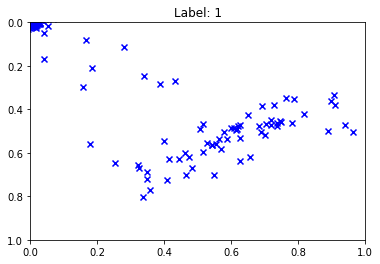

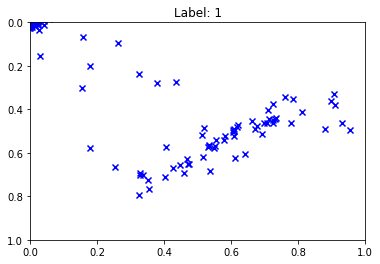

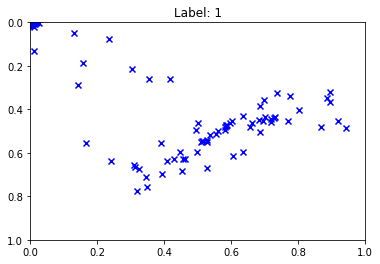

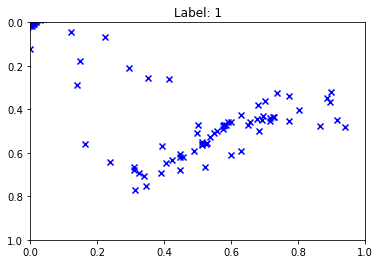

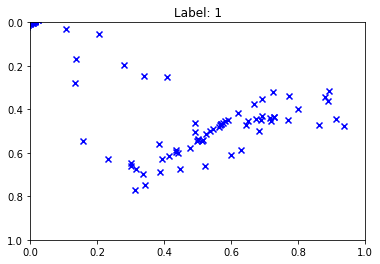

tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)


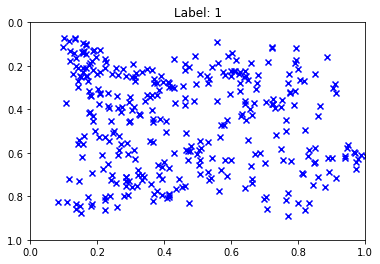

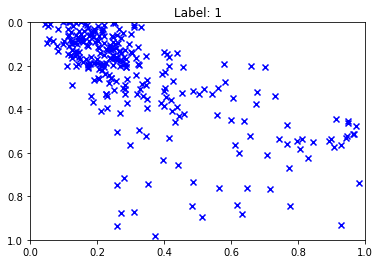

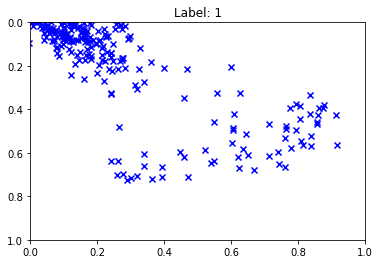

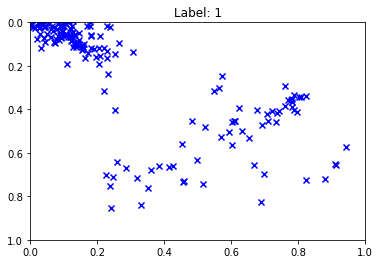

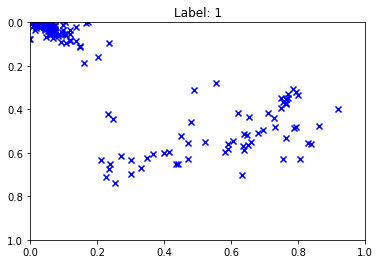

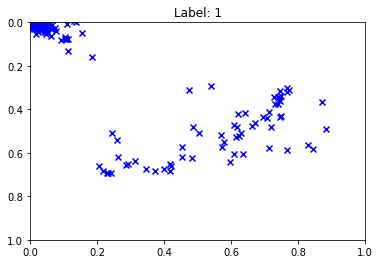

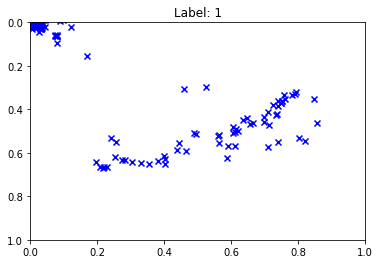

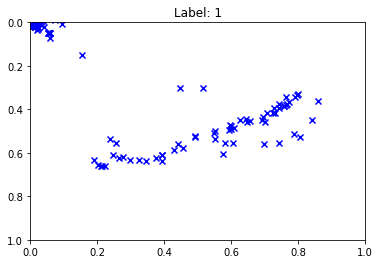

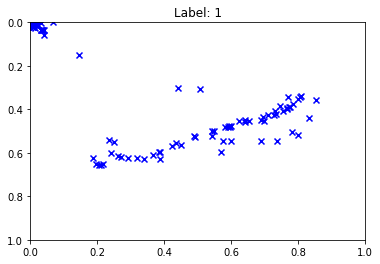

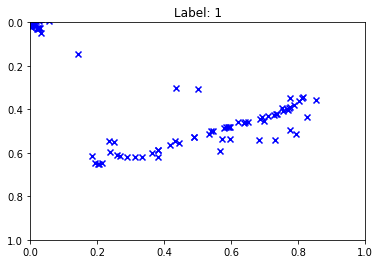

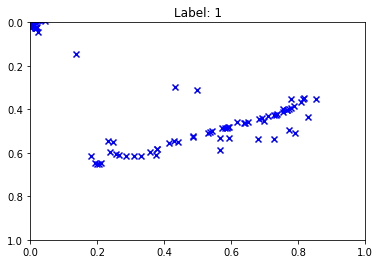

tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)


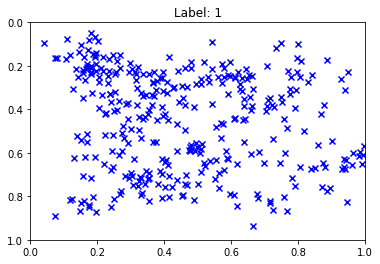

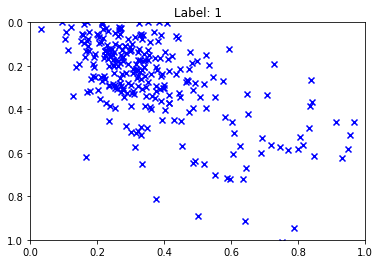

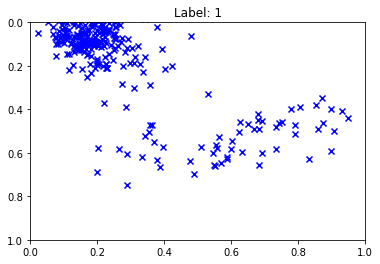

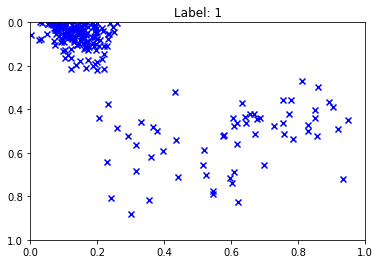

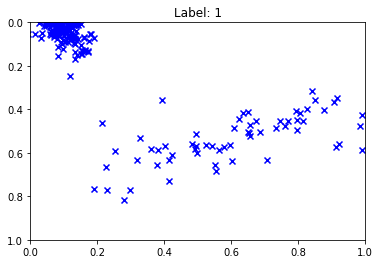

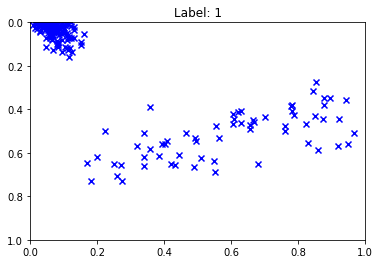

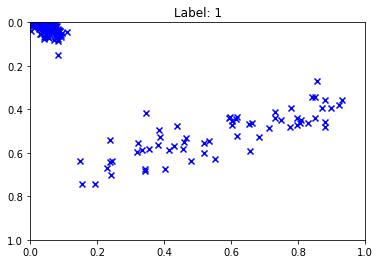

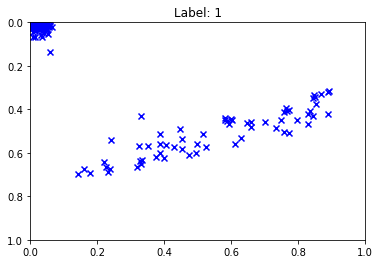

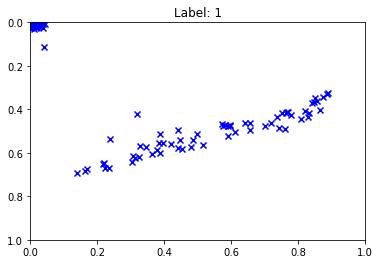

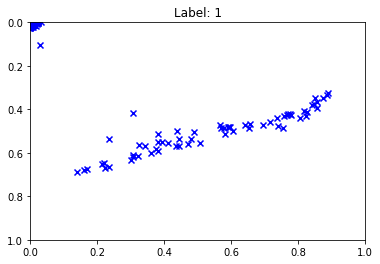

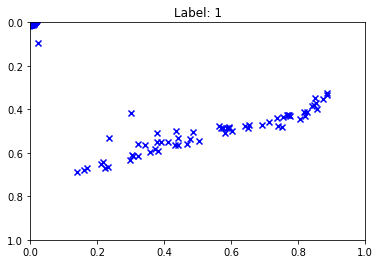

tensor(0.0003, grad_fn=<MeanBackward0>)


In [26]:
for i in range(100):
    input, target_set, target_mask = map(lambda x: x, sample)
    if(i == 1):
        print(input)
    (progress, masks, evals, gradn), (y_enc, y_label) = netHungarian(input, target_set, target_mask)
    if i == 0 or  i == 25 or i ==  50 or i == 99:
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
        for  a in progress:
          #print(a.shape)
            #a = a.cpu().data.numpy()
            x, y = a[0].detach().cpu().numpy()
            plt.scatter(x[:342], y[:342],marker='x',color ='b')
            #plt.axes().set_aspect("equal")
            plt.axis([0, 1, 1, 0])
            plt.title('Label: {}'.format(input[0]))
            #plt.savefig('test.png')
            plt.show()
            progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    a = torch.stack(progress)
  # target set is explicitly broadcasted over dim 0
    b = target_set.repeat(a.size(0), 1, 1, 1)
  # flatten inner iteration dim and batch dim
    a = a.view(-1, a.size(2), a.size(3))
    b = b.view(-1, b.size(2), b.size(3))
    set_loss = hungarian_loss(
      progress[-1], target_set
    ).unsqueeze(0)
    loss = set_loss.mean()
    #print(set_loss)
    print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
